<a href="https://colab.research.google.com/github/KaifAhmad1/code-test/blob/main/Solar_Panel_Performance_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ☀️ Solar Panel Performance Optimization Challenge ☀️

**Predicting Degradation and Failures for a Sustainable Future**

---

## 🎯 1. The Challenge: Maximizing Solar Energy Output

Solar energy is a cornerstone of sustainable power. However, the efficiency of Photovoltaic (PV) panels can degrade over time or due to unforeseen failures. Traditional maintenance is often reactive, leading to:

*   📉 **Energy Loss:** Suboptimal performance means less clean energy generated.
*   💰 **Increased Costs:** Reactive repairs and downtime are expensive.

**Our Mission:** To develop a sophisticated Machine Learning model that predicts `efficiency` (our target variable), enabling **predictive maintenance**. This proactive approach will help maintain peak performance and reduce operational interruptions.

---

## 📊 2. Understanding Our Data

We're provided with a rich dataset containing sensor readings and panel characteristics.

*   **`train.csv`**: The training ground for our model (20,000 samples, 17 features including `efficiency`).
*   **`test.csv`**: The unseen data where we'll make our predictions (12,000 samples, 16 features).
*   **`sample_submission.csv`**: The blueprint for our final submission file.

### Key Data Features at a Glance:

| Feature Category    | Column Examples                                 | Description                                                                    |
| :------------------ | :---------------------------------------------- | :----------------------------------------------------------------------------- |
| 🆔 **Identifiers**   | `id`, `string_id`                               | Unique row and panel group identifiers.                                        |
| 🌡️ **Environmental** | `temperature`, `irradiance`, `humidity`, `cloud_coverage`, `wind_speed`, `pressure` | Ambient conditions influencing panel operation.                |
| 🛠️ **Panel Specifics**| `panel_age`, `maintenance_count`, `soiling_ratio`, `module_temperature`, `error_code`, `installation_type` | Panel history, condition, and setup.                               |
| ⚡ **Electrical**   | `voltage`, `current`                            | Measured electrical output.                                                    |
| 🏆 **Target**        | **`efficiency`**                                | **The crucial variable we need to predict!** (0.0 - 1.0 scale)             |

*A detailed description of each column is available in the problem statement.*

---

## 🚀 3. Our Game Plan: Building a Winning Model

We'll follow a structured, iterative approach to tackle this prediction task:

1.  **⚙️ Initial Setup & Environment Configuration:**
    *   Importing essential Python libraries (Pandas, NumPy, Scikit-learn, LightGBM, XGBoost, Plotly, Optuna).
    *   Loading the datasets into our workspace.

2.  **🔍 Exploratory Data Analysis (EDA) - Unveiling Insights:**
    *   Deep dive into data distributions, missing values, and potential outliers.
    *   Visualizing feature relationships and their correlation with `efficiency` using:
        *   **Matplotlib & Seaborn:** For static, foundational plots.
        *   **Plotly:** For dynamic, interactive visualizations to uncover subtle patterns.

3.  **✨ Feature Engineering - Crafting Predictive Power:**
    *   Creating new, informative features from existing ones (e.g., interaction terms like `temperature * irradiance`, ratios like `module_temperature - temperature`). The goal is to provide the model with richer signals.

4.  **🧹 Data Preprocessing - Preparing for Modeling:**
    *   **Missing Value Imputation:** Strategically filling in any data gaps.
    *   **Categorical Encoding:** Transforming text-based features (like `string_id`, `error_code`) into a numerical format (One-Hot Encoding).
    *   **Feature Scaling:** Normalizing numerical features (`StandardScaler`) to ensure fair contribution from all variables.

5.  **🧠 Model Building & Cross-Validation - The Core Engine:**
    *   **Algorithm Selection:** Focusing on state-of-the-art gradient boosting models:
        *   **LightGBM (LGBM):** Known for speed and efficiency.
        *   **XGBoost:** A robust and widely-used powerhouse.
    *   **K-Fold Cross-Validation:** Training and evaluating models on different subsets of the data to ensure robustness and get a reliable performance estimate. This helps prevent overfitting.

6.  **🛠️ Hyperparameter Optimization - Fine-Tuning for Excellence:**
    *   Leveraging **Optuna**, an automated hyperparameter optimization framework. Optuna will intelligently search for the best set of model settings (e.g., learning rate, tree depth) to maximize our chosen metric.

7.  **🤝 Model Ensembling - The Power of Collaboration:**
    *   **Blending:** Combining the predictions from our fine-tuned LGBM and XGBoost models. The idea is that different models capture different aspects of the data, and their combined wisdom is often superior to any single model. We'll optimize the blending weights.

8.  **📜 Prediction & Submission - Delivering Results:**
    *   Applying our final, ensembled model to the `test.csv` data.
    *   Generating the `submission.csv` file in the specified format.

---

## 📈 4. Measuring Success: The Evaluation Metric

Our model's prowess will be judged by a custom scoring formula:

**Score = 100 \* (1 - RMSE)**

Where `RMSE` (Root Mean Squared Error) is calculated as:
`RMSE = sqrt(mean_squared_error(actual_efficiency, predicted_efficiency))`

**A higher score indicates a more accurate model.** Our goal is to maximize this score!

---

## 🏁 Let's Begin the Journey!

The code cells below will bring this plan to life. We'll document each step, share our findings, and strive for the best possible prediction model.

In [1]:
!pip install pandas numpy matplotlib seaborn plotly scikit-learn lightgbm xgboost optuna shap catboost kaleido -q

In [3]:
# Core Data Science Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning Libraries
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer # <--- ADD THIS LINE
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Hyperparameter Optimization
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Model Interpretability
import shap

# Utility Libraries
import os
import time
from datetime import datetime

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 Environment Setup Complete!")
print(f"📅 Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🚀 Environment Setup Complete!
📅 Analysis started at: 2025-05-27 06:05:39


In [4]:
# =============================================================================
# STEP 1: CONFIGURATION & GLOBAL SETTINGS
# =============================================================================

class Config:
    """Configuration class for the entire pipeline"""

    # Model Training Settings
    RANDOM_STATE = 42
    N_SPLITS = 5
    TEST_SIZE = 0.2

    # Hyperparameter Optimization
    RUN_OPTUNA = True
    OPTUNA_TRIALS_LGBM = 50
    OPTUNA_TRIALS_XGB = 50
    OPTUNA_TRIALS_CATBOOST = 30

    # Data Processing
    USE_ITERATIVE_IMPUTER = False
    SHAP_SAMPLE_SIZE = 1000

    # Visualization Settings
    FIGURE_SIZE = (12, 8)
    DPI = 300

    # File Paths (adjust as needed)
    DATA_PATH = "/content/drive/MyDrive/zelestra_data/"
    OUTPUT_DIR = "solar_panel_analysis_v4"

    # Target Variable
    TARGET = 'efficiency'

config = Config()

# Create output directories
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{config.OUTPUT_DIR}/plots", exist_ok=True)
os.makedirs(f"{config.OUTPUT_DIR}/models", exist_ok=True)

print("⚙️ Configuration loaded successfully!")

⚙️ Configuration loaded successfully!


In [5]:
# =============================================================================
# STEP 2: DATA LOADING & INITIAL EXPLORATION
# =============================================================================

def load_data():
    """Load and perform initial exploration of the datasets"""

    print("\n" + "="*60)
    print("📊 DATA LOADING & INITIAL EXPLORATION")
    print("="*60)

    try:
        # Load datasets
        train_df = pd.read_csv(os.path.join(config.DATA_PATH, "train.csv"))
        test_df = pd.read_csv(os.path.join(config.DATA_PATH, "test.csv"))
        sample_submission = pd.read_csv(os.path.join(config.DATA_PATH, "sample_submission.csv"))

        print(f"✅ Data loaded successfully!")
        print(f"📈 Train data shape: {train_df.shape}")
        print(f"📊 Test data shape: {test_df.shape}")
        print(f"📝 Sample submission shape: {sample_submission.shape}")

        return train_df, test_df, sample_submission

    except FileNotFoundError as e:
        print(f"❌ Error loading data: {e}")
        print(f"📂 Please ensure data files are in: {config.DATA_PATH}")
        return None, None, None

def initial_data_exploration(train_df, test_df):
    """Perform comprehensive initial data exploration"""

    print("\n📋 DATASET OVERVIEW")
    print("-" * 30)

    # Basic info
    print("🔍 Train Dataset Info:")
    print(f"   Rows: {train_df.shape[0]:,}")
    print(f"   Columns: {train_df.shape[1]}")
    print(f"   Memory usage: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    print("\n📊 Column Information:")
    info_df = pd.DataFrame({
        'Column': train_df.columns,
        'Type': train_df.dtypes,
        'Non-Null': train_df.count(),
        'Null %': (train_df.isnull().sum() / len(train_df) * 100).round(2)
    })
    print(info_df.to_string(index=False))

    # Target variable analysis
    if config.TARGET in train_df.columns:
        print(f"\n🎯 TARGET VARIABLE ({config.TARGET}) ANALYSIS:")
        print(f"   Min: {train_df[config.TARGET].min():.4f}")
        print(f"   Max: {train_df[config.TARGET].max():.4f}")
        print(f"   Mean: {train_df[config.TARGET].mean():.4f}")
        print(f"   Std: {train_df[config.TARGET].std():.4f}")
        print(f"   Median: {train_df[config.TARGET].median():.4f}")
        print(f"   Skewness: {train_df[config.TARGET].skew():.4f}")
        print(f"   Kurtosis: {train_df[config.TARGET].kurtosis():.4f}")

    return info_df

# Load data
train_df, test_df, sample_submission = load_data()

if train_df is not None:
    # Initial exploration
    info_df = initial_data_exploration(train_df, test_df)

    # Display first few rows
    print("\n📋 First 5 rows of training data:")
    display(train_df.head())
else:
    print("❌ Cannot proceed without data. Please check your data path.")


📊 DATA LOADING & INITIAL EXPLORATION
✅ Data loaded successfully!
📈 Train data shape: (20000, 17)
📊 Test data shape: (12000, 16)
📝 Sample submission shape: (5, 2)

📋 DATASET OVERVIEW
------------------------------
🔍 Train Dataset Info:
   Rows: 20,000
   Columns: 17
   Memory usage: 9.12 MB

📊 Column Information:
            Column    Type  Non-Null  Null %
                id   int64     20000    0.00
       temperature float64     18999    5.00
        irradiance float64     19013    4.93
          humidity  object     20000    0.00
         panel_age float64     18989    5.06
 maintenance_count float64     18973    5.14
     soiling_ratio float64     18990    5.05
           voltage float64     19007    4.96
           current float64     19023    4.88
module_temperature float64     19022    4.89
    cloud_coverage float64     18990    5.05
        wind_speed  object     20000    0.00
          pressure  object     20000    0.00
         string_id  object     20000    0.00
        er

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type,efficiency
0,0,7.817315,576.179270,41.24308670850264,32.135501,4.0,0.803199,37.403527,1.963787,13.691147,62.494044,12.82491203459621,1018.8665053152533,A1,NaN,NaN,0.562096
1,1,24.785727,240.003973,1.3596482765960705,19.977460,8.0,0.479456,21.843315,0.241473,27.545096,43.851238,12.012043660984917,1025.6238537572883,D4,E00,dual-axis,0.396447
2,2,46.652695,687.612799,91.26536837560256,1.496401,4.0,0.822398,48.222882,4.191800,43.363708,NaN,1.814399755560454,1010.9226539809573,C3,E00,NaN,0.573776
3,3,53.339567,735.141179,96.19095521176159,18.491582,3.0,0.837529,46.295748,0.960567,57.720436,67.361473,8.736258932034128,1021.8466633134253,A1,NaN,dual-axis,0.629009
4,4,5.575374,12.241203,27.495073003585226,30.722697,6.0,0.551833,0.000000,0.898062,6.786263,3.632000,0.52268384077164,1008.5559577591927,B2,E00,fixed,0.341874


In [6]:
# =============================================================================
# STEP 3: DATA CLEANING & PREPROCESSING
# =============================================================================

def clean_data(df, df_name="DataFrame"):
    """Clean and preprocess the data"""

    print(f"\n🧹 CLEANING {df_name.upper()}")
    print("-" * 40)

    df_cleaned = df.copy()

    # Convert problematic columns to numeric
    cols_to_numeric = ['humidity', 'wind_speed', 'pressure']

    for col in cols_to_numeric:
        if col in df_cleaned.columns:
            original_non_numeric = pd.to_numeric(df_cleaned[col], errors='coerce').isnull().sum()
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
            new_nans = df_cleaned[col].isnull().sum()
            if original_non_numeric > 0:
                print(f"   📊 {col}: Converted {original_non_numeric} non-numeric values to NaN")

    # Handle categorical variables
    categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
    if 'id' in categorical_cols:
        categorical_cols.remove('id')

    print(f"   📊 Found {len(categorical_cols)} categorical columns: {categorical_cols}")

    # Check for duplicates
    duplicates = df_cleaned.duplicated().sum()
    if duplicates > 0:
        print(f"   ⚠️ Found {duplicates} duplicate rows")
        df_cleaned = df_cleaned.drop_duplicates()
        print(f"   ✅ Removed duplicates. New shape: {df_cleaned.shape}")

    return df_cleaned

# Clean the data
train_cleaned = clean_data(train_df, "Train Data")
test_cleaned = clean_data(test_df, "Test Data")

print("✅ Data cleaning completed!")


🧹 CLEANING TRAIN DATA
----------------------------------------
   📊 humidity: Converted 127 non-numeric values to NaN
   📊 wind_speed: Converted 119 non-numeric values to NaN
   📊 pressure: Converted 135 non-numeric values to NaN
   📊 Found 3 categorical columns: ['string_id', 'error_code', 'installation_type']

🧹 CLEANING TEST DATA
----------------------------------------
   📊 humidity: Converted 73 non-numeric values to NaN
   📊 wind_speed: Converted 81 non-numeric values to NaN
   📊 pressure: Converted 65 non-numeric values to NaN
   📊 Found 3 categorical columns: ['string_id', 'error_code', 'installation_type']
✅ Data cleaning completed!



🔍 COMPREHENSIVE EXPLORATORY DATA ANALYSIS


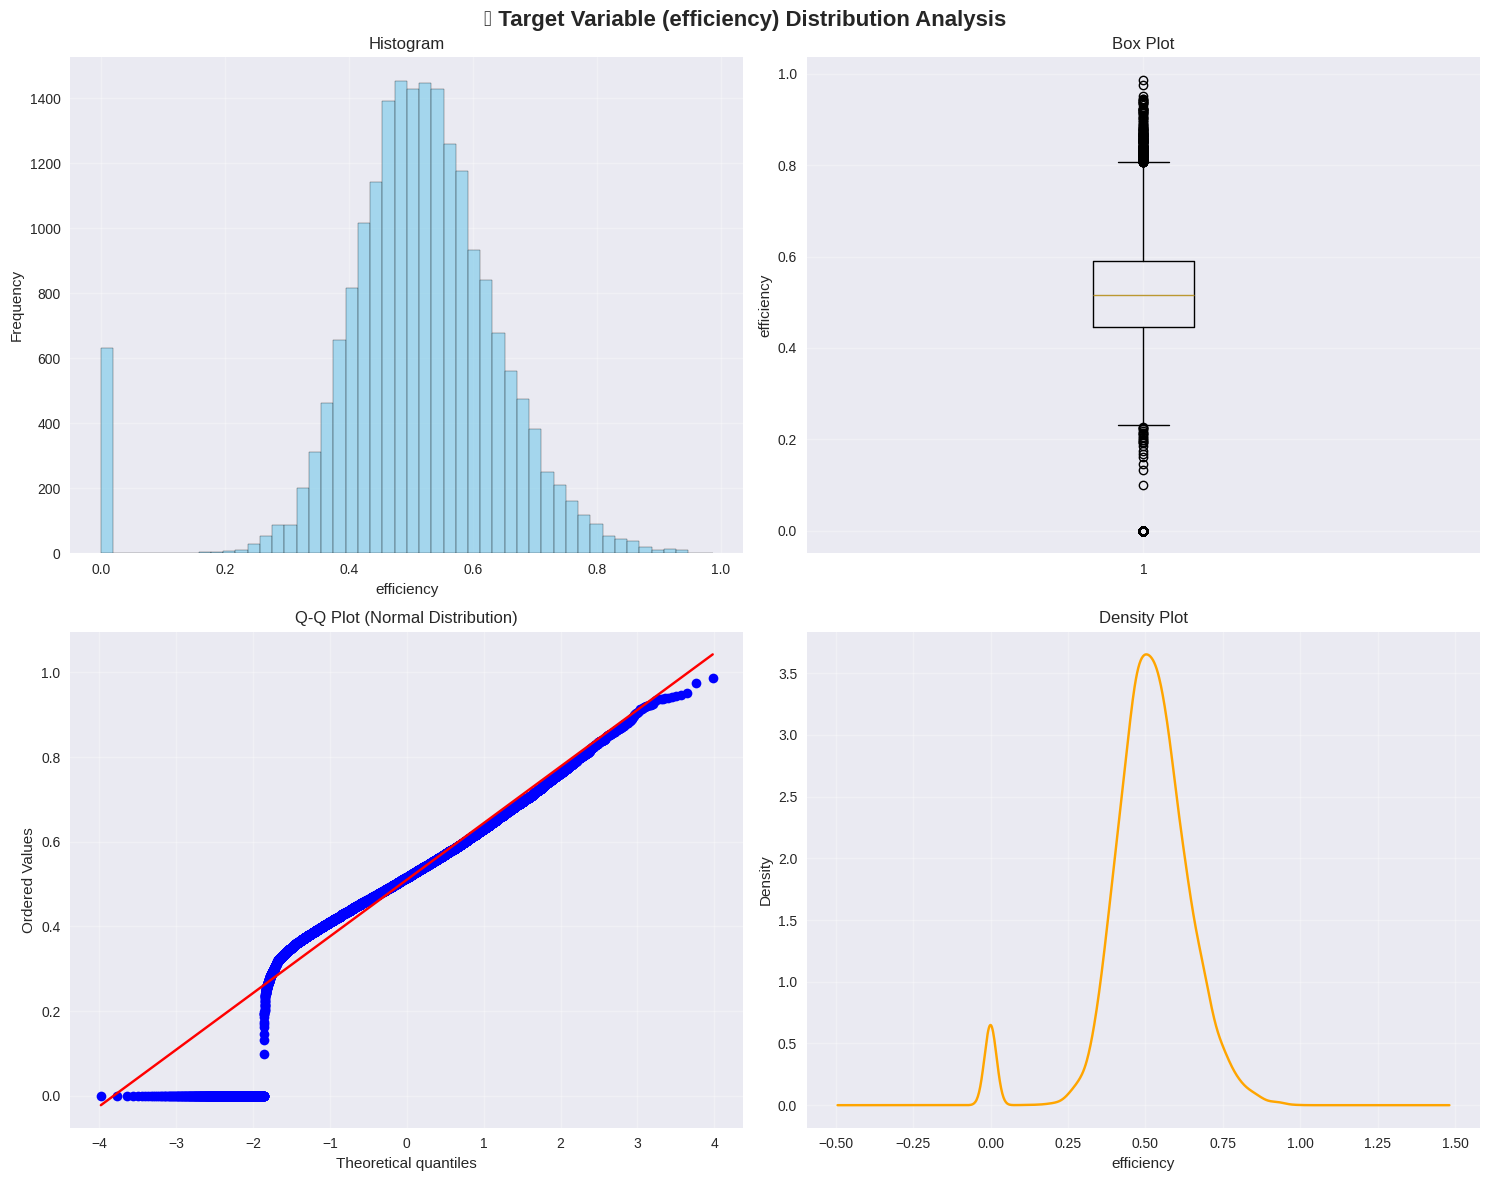

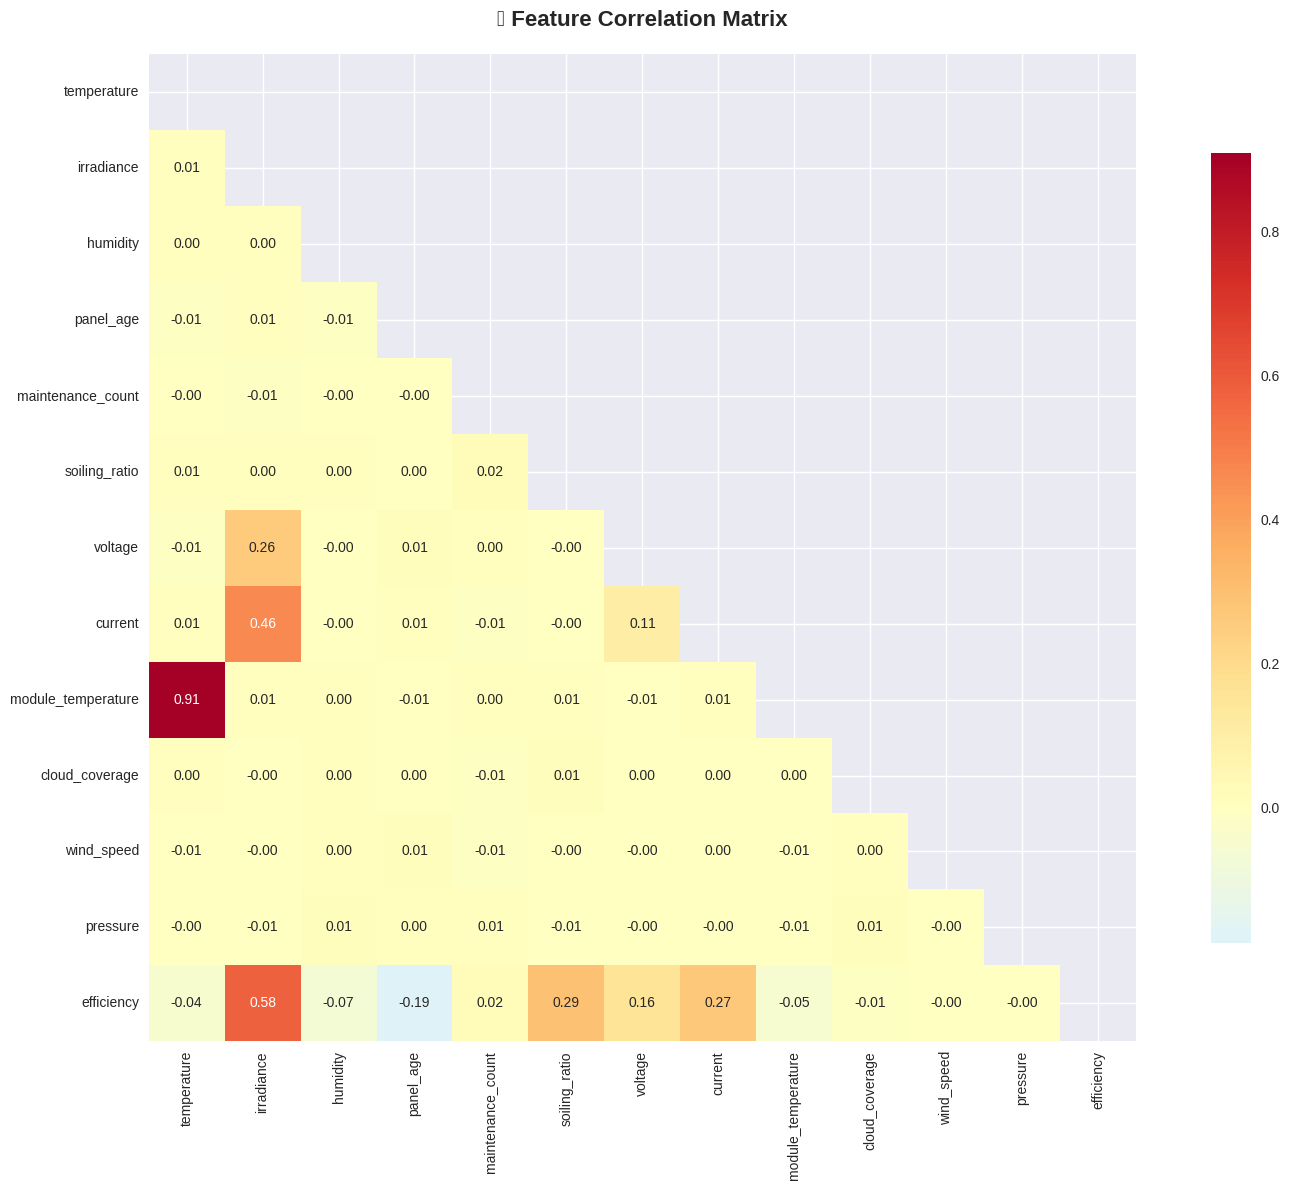

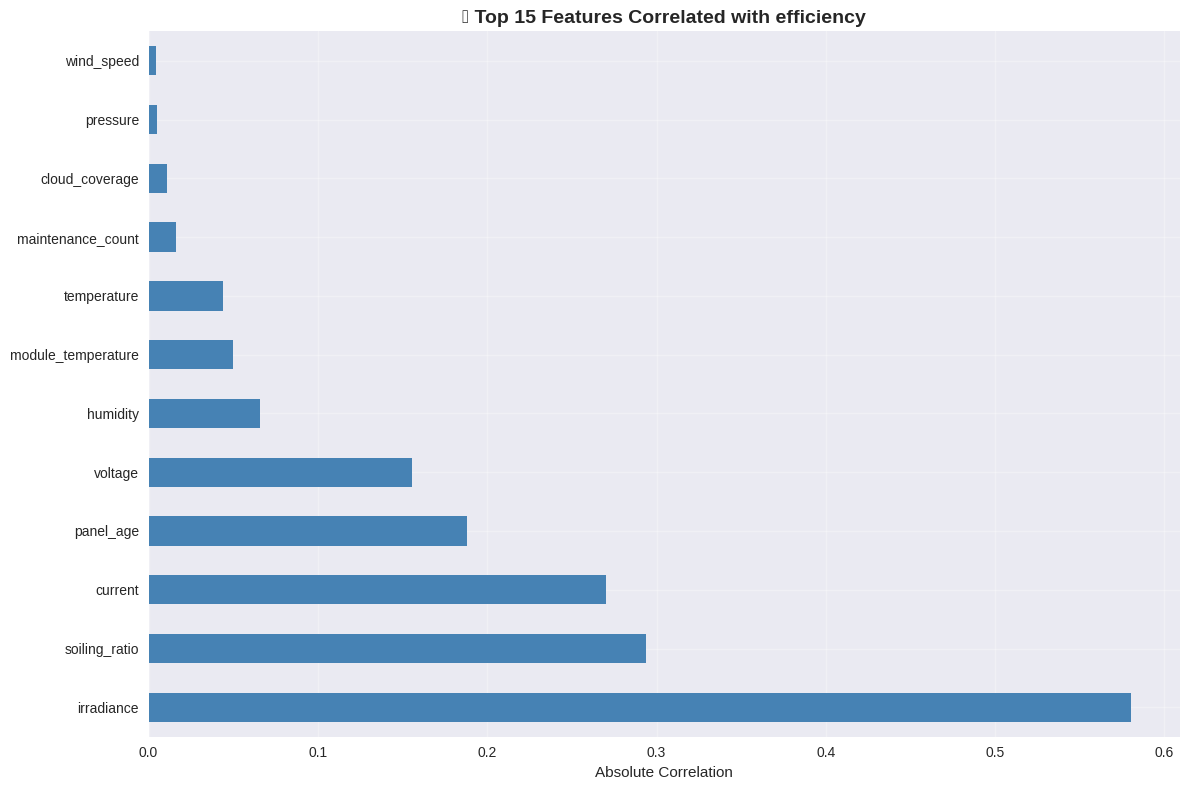

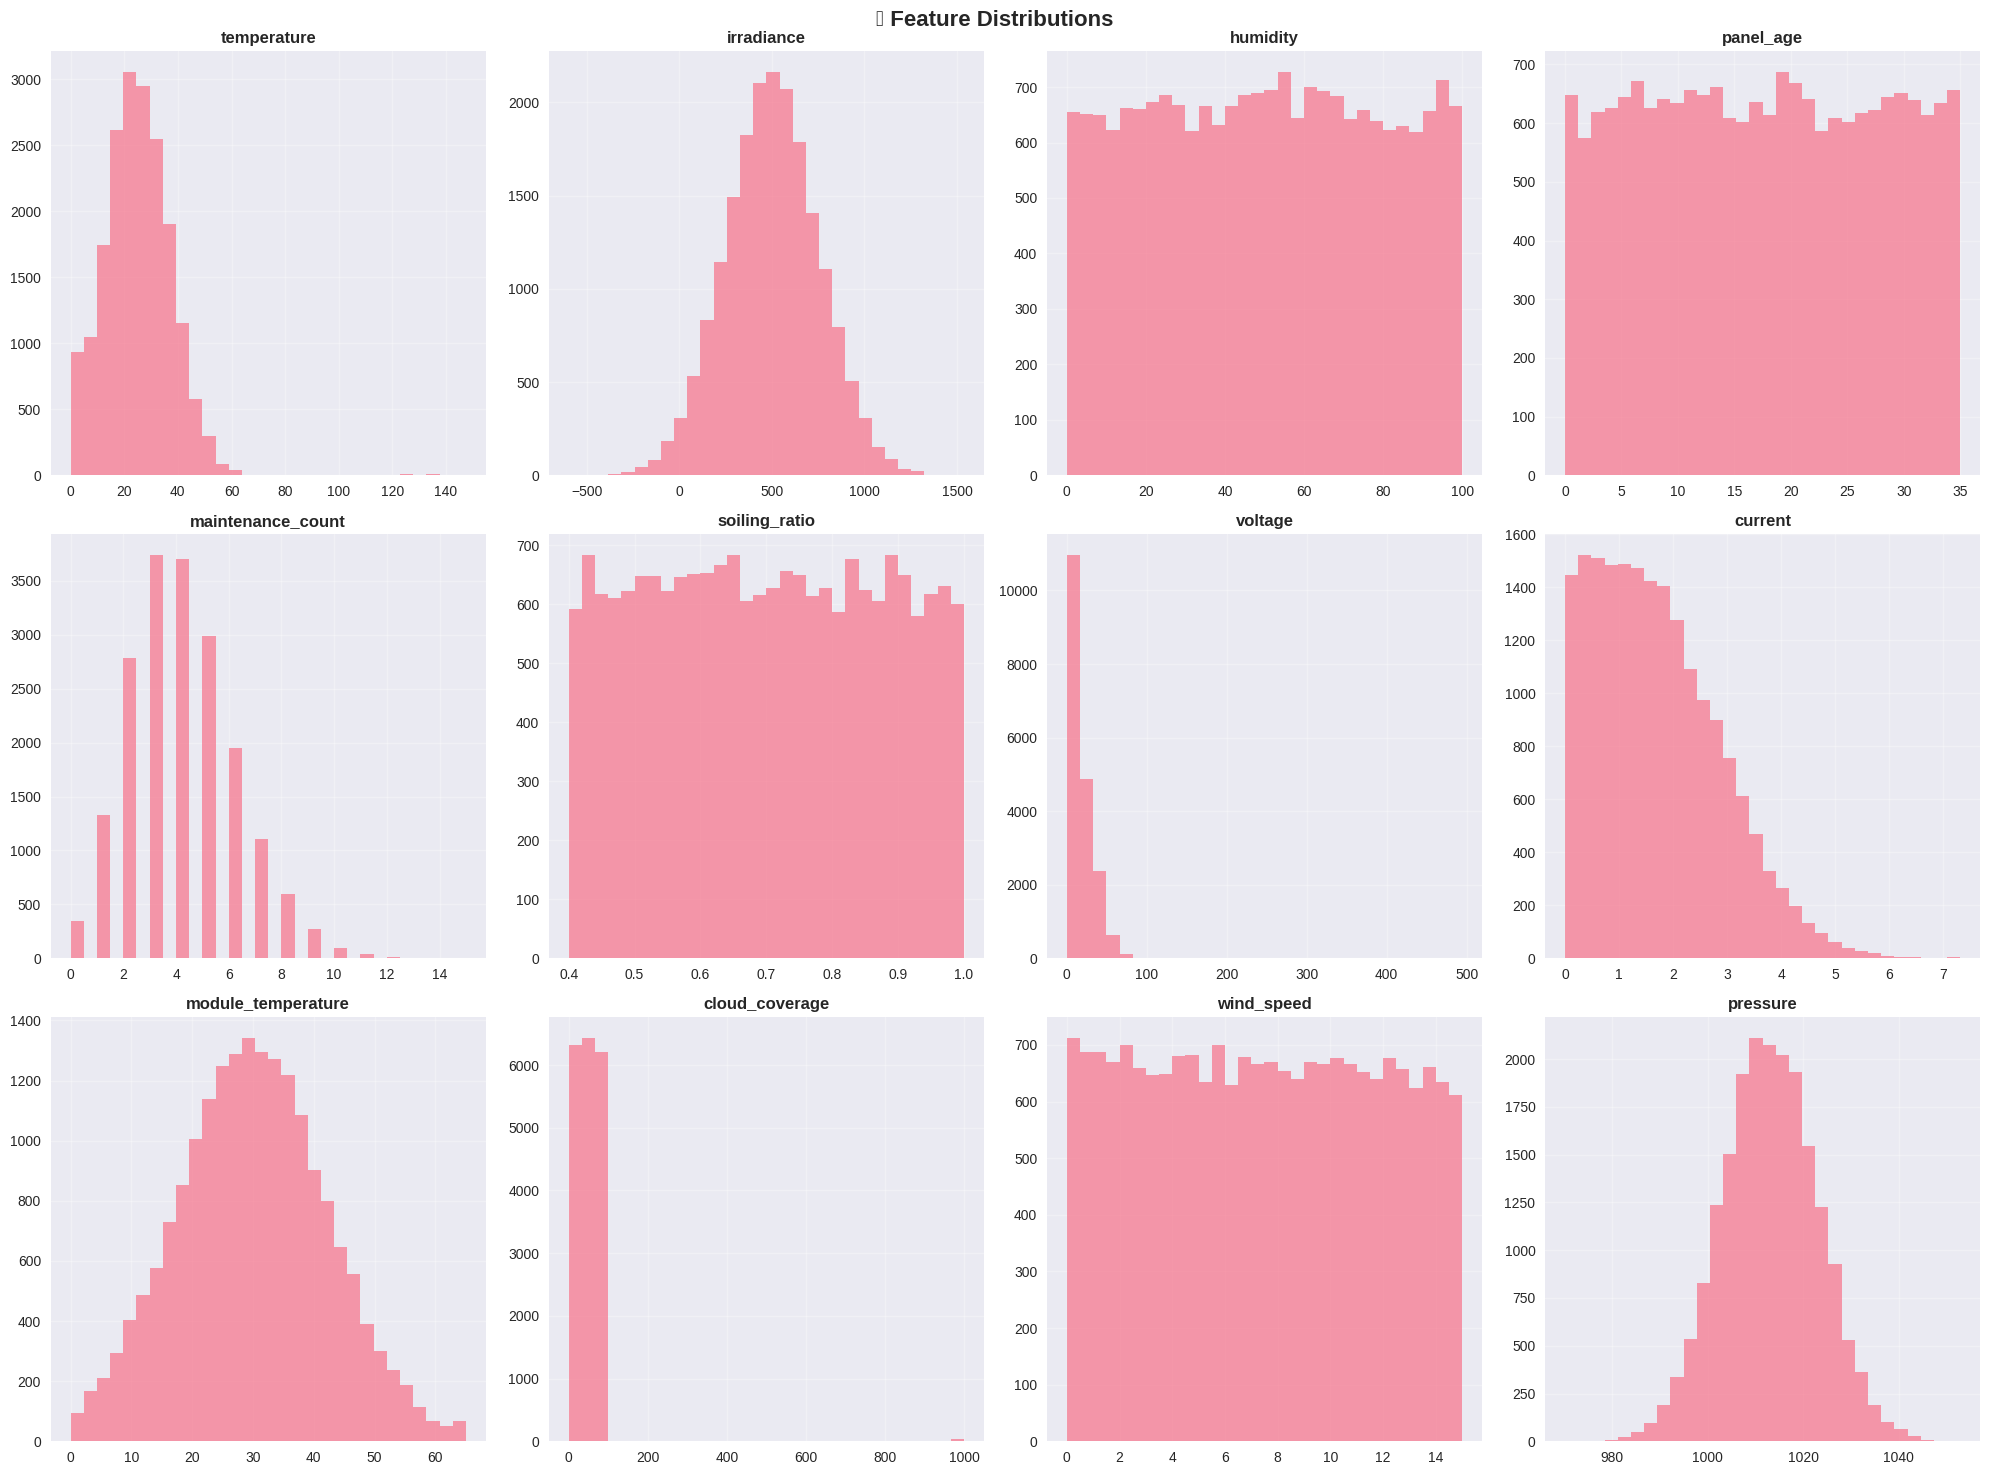


🔍 MISSING DATA ANALYSIS
----------------------------------------
📊 Columns with missing data:
            Column  Missing Count  Missing Percentage
        error_code           5912              29.560
 installation_type           5028              25.140
 maintenance_count           1027               5.135
         panel_age           1011               5.055
     soiling_ratio           1010               5.050
    cloud_coverage           1010               5.050
       temperature           1001               5.005
           voltage            993               4.965
        irradiance            987               4.935
module_temperature            978               4.890
           current            977               4.885
          pressure            135               0.675
          humidity            127               0.635
        wind_speed            119               0.595


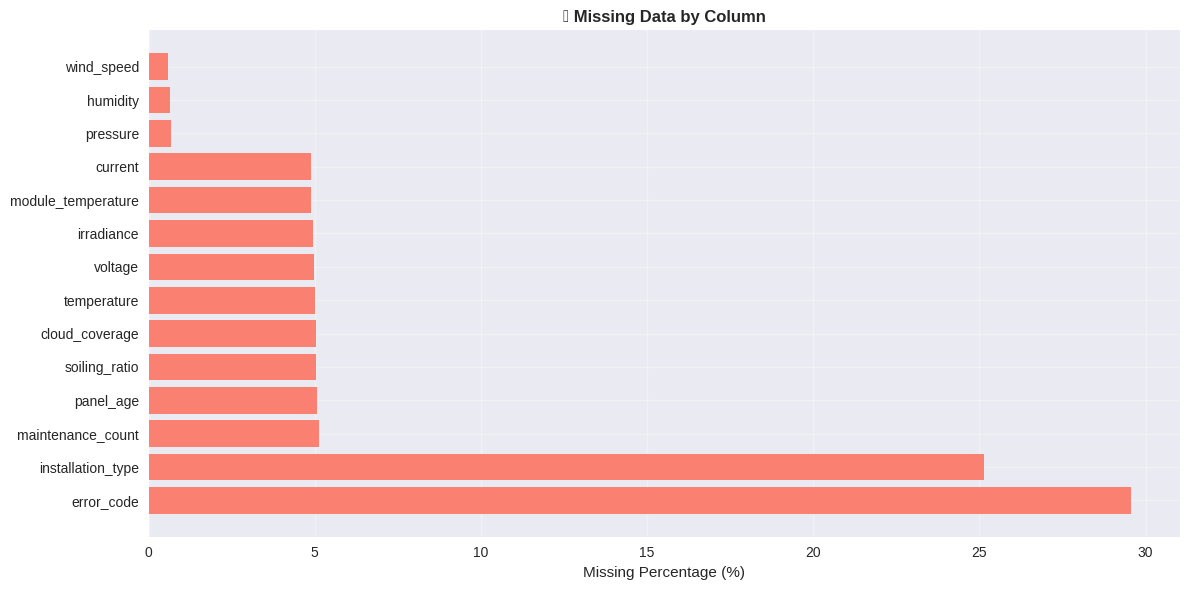


📊 CATEGORICAL VARIABLES ANALYSIS
----------------------------------------

🏷️ string_id:
   Unique values: 4
   Most common: D4 (5080 occurrences)


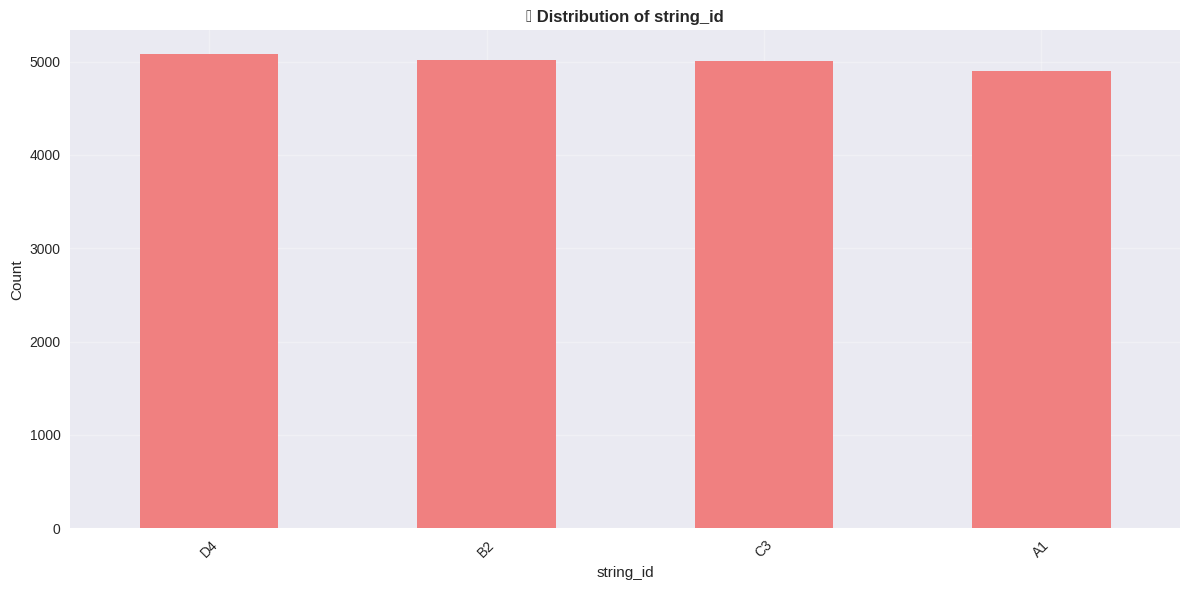


🏷️ error_code:
   Unique values: 3
   Most common: E00 (5977 occurrences)


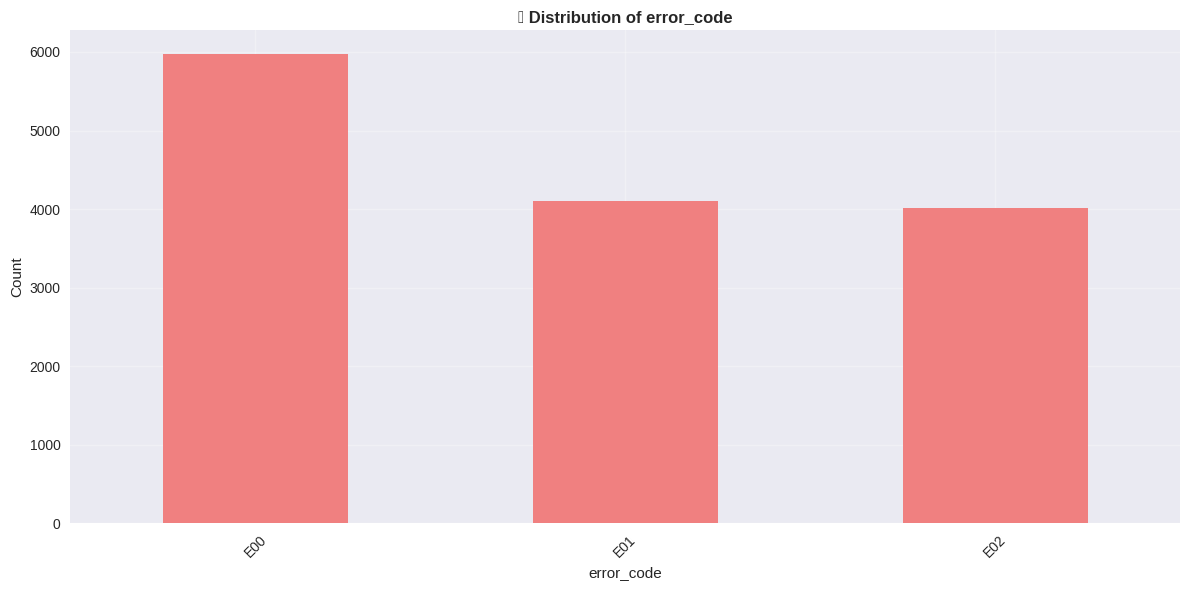


🏷️ installation_type:
   Unique values: 3
   Most common: tracking (5067 occurrences)


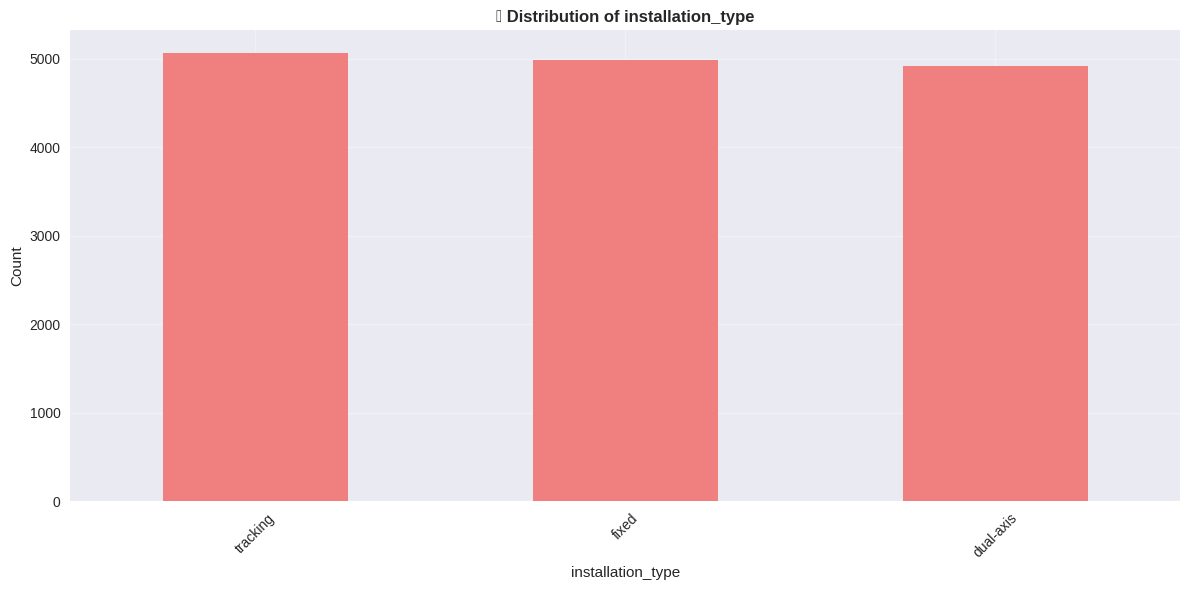

In [7]:
# =============================================================================
# STEP 4: COMPREHENSIVE EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

def create_target_distribution_plot(df, target_col):
    """Create comprehensive target distribution visualization"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'📊 Target Variable ({target_col}) Distribution Analysis', fontsize=16, fontweight='bold')

    # Histogram
    axes[0, 0].hist(df[target_col], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Histogram')
    axes[0, 0].set_xlabel(target_col)
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)

    # Box plot
    axes[0, 1].boxplot(df[target_col])
    axes[0, 1].set_title('Box Plot')
    axes[0, 1].set_ylabel(target_col)
    axes[0, 1].grid(True, alpha=0.3)

    # Q-Q plot
    from scipy import stats
    stats.probplot(df[target_col], dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot (Normal Distribution)')
    axes[1, 0].grid(True, alpha=0.3)

    # Density plot
    df[target_col].plot.density(ax=axes[1, 1], color='orange')
    axes[1, 1].set_title('Density Plot')
    axes[1, 1].set_xlabel(target_col)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{config.OUTPUT_DIR}/plots/target_distribution.png", dpi=config.DPI, bbox_inches='tight')
    plt.show()

def create_correlation_analysis(df):
    """Create comprehensive correlation analysis"""

    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'id' in numeric_cols:
        numeric_cols.remove('id')

    # Calculate correlation matrix
    corr_matrix = df[numeric_cols].corr()

    # Create correlation heatmap
    plt.figure(figsize=(16, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix,
                mask=mask,
                annot=True,
                cmap='RdYlBu_r',
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={"shrink": .8})

    plt.title('📊 Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(f"{config.OUTPUT_DIR}/plots/correlation_matrix.png", dpi=config.DPI, bbox_inches='tight')
    plt.show()

    # Top correlations with target
    if config.TARGET in corr_matrix.columns:
        target_corr = corr_matrix[config.TARGET].abs().sort_values(ascending=False)
        target_corr = target_corr[target_corr.index != config.TARGET]

        plt.figure(figsize=(12, 8))
        target_corr.head(15).plot(kind='barh', color='steelblue')
        plt.title(f'🎯 Top 15 Features Correlated with {config.TARGET}', fontsize=14, fontweight='bold')
        plt.xlabel('Absolute Correlation')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{config.OUTPUT_DIR}/plots/target_correlations.png", dpi=config.DPI, bbox_inches='tight')
        plt.show()

        return target_corr

    return None

def create_feature_distributions(df, n_cols=4):
    """Create distribution plots for all numeric features"""

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'id' in numeric_cols:
        numeric_cols.remove('id')
    if config.TARGET in numeric_cols:
        numeric_cols.remove(config.TARGET)

    n_features = len(numeric_cols)
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else []

    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            df[col].hist(bins=30, alpha=0.7, ax=axes[i])
            axes[i].set_title(f'{col}', fontweight='bold')
            axes[i].grid(True, alpha=0.3)

    # Hide empty subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)

    plt.suptitle('📊 Feature Distributions', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{config.OUTPUT_DIR}/plots/feature_distributions.png", dpi=config.DPI, bbox_inches='tight')
    plt.show()

def analyze_missing_data(df):
    """Comprehensive missing data analysis"""

    print("\n🔍 MISSING DATA ANALYSIS")
    print("-" * 40)

    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100

    missing_df = pd.DataFrame({
        'Column': missing_data.index,
        'Missing Count': missing_data.values,
        'Missing Percentage': missing_percent.values
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Percentage', ascending=False)

    if len(missing_df) > 0:
        print("📊 Columns with missing data:")
        print(missing_df.to_string(index=False))

        # Visualization
        if len(missing_df) > 0:
            plt.figure(figsize=(12, 6))
            plt.barh(missing_df['Column'], missing_df['Missing Percentage'], color='salmon')
            plt.xlabel('Missing Percentage (%)')
            plt.title('📊 Missing Data by Column', fontweight='bold')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(f"{config.OUTPUT_DIR}/plots/missing_data.png", dpi=config.DPI, bbox_inches='tight')
            plt.show()
    else:
        print("✅ No missing data found!")

    return missing_df

def create_categorical_analysis(df):
    """Analyze categorical variables"""

    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    if 'id' in categorical_cols:
        categorical_cols.remove('id')

    if len(categorical_cols) == 0:
        print("ℹ️ No categorical columns found for analysis")
        return

    print(f"\n📊 CATEGORICAL VARIABLES ANALYSIS")
    print("-" * 40)

    for col in categorical_cols:
        print(f"\n🏷️ {col}:")
        value_counts = df[col].value_counts()
        print(f"   Unique values: {len(value_counts)}")
        print(f"   Most common: {value_counts.index[0]} ({value_counts.iloc[0]} occurrences)")

        if len(value_counts) <= 20:  # Only plot if reasonable number of categories
            plt.figure(figsize=(12, 6))
            value_counts.plot(kind='bar', color='lightcoral')
            plt.title(f'📊 Distribution of {col}', fontweight='bold')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(f"{config.OUTPUT_DIR}/plots/categorical_{col}.png", dpi=config.DPI, bbox_inches='tight')
            plt.show()

# Perform comprehensive EDA
print("\n" + "="*60)
print("🔍 COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
print("="*60)

# Target distribution
if config.TARGET in train_cleaned.columns:
    create_target_distribution_plot(train_cleaned, config.TARGET)

# Correlation analysis
target_correlations = create_correlation_analysis(train_cleaned)

# Feature distributions
create_feature_distributions(train_cleaned)

# Missing data analysis
missing_analysis = analyze_missing_data(train_cleaned)

# Categorical analysis
create_categorical_analysis(train_cleaned)

In [8]:
# =============================================================================
# STEP 5: ADVANCED FEATURE ENGINEERING
# =============================================================================

def create_advanced_features(df):
    """Create sophisticated feature engineering"""

    print("\n⚙️ ADVANCED FEATURE ENGINEERING")
    print("-" * 40)

    df_fe = df.copy()
    original_features = len(df_fe.columns)

    print("🔧 Creating interaction features...")

    # Environmental interactions
    if 'temperature' in df_fe and 'irradiance' in df_fe:
        df_fe['temp_irradiance_interaction'] = df_fe['temperature'] * df_fe['irradiance']
        df_fe['temp_irradiance_ratio'] = df_fe['temperature'] / (df_fe['irradiance'] + 1e-6)

    if 'humidity' in df_fe and 'temperature' in df_fe:
        df_fe['humidity_temp_interaction'] = df_fe['humidity'] * df_fe['temperature']
        df_fe['heat_index'] = df_fe['temperature'] + (df_fe['humidity'] / 100) * 10

    if 'wind_speed' in df_fe and 'temperature' in df_fe:
        df_fe['wind_chill'] = df_fe['temperature'] - df_fe['wind_speed'] * 0.5

    # Electrical features
    if 'voltage' in df_fe and 'current' in df_fe:
        df_fe['power'] = df_fe['voltage'] * df_fe['current']
        df_fe['voltage_current_ratio'] = df_fe['voltage'] / (df_fe['current'] + 1e-6)

    # Panel condition features
    if 'panel_age' in df_fe and 'maintenance_count' in df_fe:
        df_fe['maintenance_per_age'] = df_fe['maintenance_count'] / (df_fe['panel_age'] + 1)
        df_fe['age_maintenance_interaction'] = df_fe['panel_age'] * df_fe['maintenance_count']

    if 'soiling_ratio' in df_fe and 'irradiance' in df_fe:
        df_fe['effective_irradiance'] = df_fe['irradiance'] * df_fe['soiling_ratio']

    print("📊 Creating statistical features...")

    # Temperature features
    temp_cols = [col for col in df_fe.columns if 'temp' in col.lower()]
    if len(temp_cols) > 1:
        df_fe['temp_mean'] = df_fe[temp_cols].mean(axis=1)
        df_fe['temp_std'] = df_fe[temp_cols].std(axis=1)
        df_fe['temp_range'] = df_fe[temp_cols].max(axis=1) - df_fe[temp_cols].min(axis=1)

    # Polynomial features for key variables
    key_vars = ['irradiance', 'temperature', 'voltage', 'current', 'panel_age']
    for var in key_vars:
        if var in df_fe.columns:
            df_fe[f'{var}_squared'] = df_fe[var] ** 2
            df_fe[f'{var}_cubed'] = df_fe[var] ** 3
            df_fe[f'{var}_sqrt'] = np.sqrt(np.abs(df_fe[var]))
            df_fe[f'{var}_log'] = np.log1p(np.abs(df_fe[var]))

    print("🏷️ Creating categorical features...")

    # Binning continuous variables
    if 'panel_age' in df_fe:
        df_fe['age_category'] = pd.cut(df_fe['panel_age'],
                                       bins=[0, 1, 3, 5, 10, float('inf')],
                                       labels=['New', 'Young', 'Mature', 'Old', 'Ancient'])

    if 'temperature' in df_fe:
        df_fe['temp_category'] = pd.cut(df_fe['temperature'],
                                        bins=[-float('inf'), 10, 20, 30, float('inf')],
                                        labels=['Cold', 'Cool', 'Warm', 'Hot'])

    if 'irradiance' in df_fe:
        df_fe['irradiance_category'] = pd.cut(df_fe['irradiance'],
                                              bins=[-float('inf'), 200, 500, 800, float('inf')],
                                              labels=['Low', 'Medium', 'High', 'Very_High'])

    new_features = len(df_fe.columns) - original_features
    print(f"✅ Created {new_features} new features!")
    print(f"📊 Total features: {len(df_fe.columns)}")

    return df_fe

def select_features(X, y, method='correlation', k=50):
    """Feature selection using various methods"""

    print(f"\n🎯 FEATURE SELECTION (Method: {method})")
    print("-" * 40)

    if method == 'correlation':
        # Select features based on correlation with target
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        correlations = X[numeric_cols].corrwith(y).abs().sort_values(ascending=False)
        selected_features = correlations.head(k).index.tolist()

    elif method == 'mutual_info':
        from sklearn.feature_selection import mutual_info_regression, SelectKBest

        # Handle categorical variables
        X_encoded = X.copy()
        categorical_cols = X_encoded.select_dtypes(include=['object']).columns

        for col in categorical_cols:
            le = LabelEncoder()
            X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

        selector = SelectKBest(score_func=mutual_info_regression, k=k)
        selector.fit(X_encoded, y)
        selected_features = X_encoded.columns[selector.get_support()].tolist()

    elif method == 'random_forest':
        # Use Random Forest feature importance
        X_encoded = X.copy()
        categorical_cols = X_encoded.select_dtypes(include=['object']).columns

        for col in categorical_cols:
            le = LabelEncoder()
            X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

        rf = RandomForestRegressor(n_estimators=100, random_state=config.RANDOM_STATE)
        rf.fit(X_encoded, y)

        feature_importance = pd.DataFrame({
            'feature': X_encoded.columns,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)

        selected_features = feature_importance.head(k)['feature'].tolist()

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(20)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('🎯 Top 20 Feature Importances (Random Forest)', fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f"{config.OUTPUT_DIR}/plots/feature_importance_rf.png", dpi=config.DPI, bbox_inches='tight')
        plt.show()

    print(f"✅ Selected {len(selected_features)} features using {method}")
    return selected_features

# Apply feature engineering
train_fe = create_advanced_features(train_cleaned)
test_fe = create_advanced_features(test_cleaned)

# Prepare features for modeling
X = train_fe.drop([config.TARGET, 'id'], axis=1, errors='ignore')
y = train_fe[config.TARGET]
X_test_full = test_fe.drop('id', axis=1, errors='ignore')

# Ensure same features in train and test
common_features = list(set(X.columns) & set(X_test_full.columns))
X = X[common_features]
X_test = X_test_full[common_features]

print(f"\n📊 Final dataset shapes:")
print(f"   Training: {X.shape}")
print(f"   Test: {X_test.shape}")

# Feature selection
selected_features = select_features(X, y, method='random_forest', k=50)
X_selected = X[selected_features]
X_test_selected = X_test[selected_features]

print(f"📊 Selected features shape: {X_selected.shape}")


⚙️ ADVANCED FEATURE ENGINEERING
----------------------------------------
🔧 Creating interaction features...
📊 Creating statistical features...
🏷️ Creating categorical features...
✅ Created 36 new features!
📊 Total features: 53

⚙️ ADVANCED FEATURE ENGINEERING
----------------------------------------
🔧 Creating interaction features...
📊 Creating statistical features...
🏷️ Creating categorical features...
✅ Created 36 new features!
📊 Total features: 52

📊 Final dataset shapes:
   Training: (20000, 51)
   Test: (12000, 51)

🎯 FEATURE SELECTION (Method: random_forest)
----------------------------------------


ValueError: could not convert string to float: 'Cold'

In [9]:
# =============================================================================
# STEP 6: ADVANCED PREPROCESSING PIPELINE
# =============================================================================

def create_preprocessing_pipeline():
    """Create a robust preprocessing pipeline"""

    print("\n🛠️ CREATING PREPROCESSING PIPELINE")
    print("-" * 40)

    # Identify numeric and categorical columns
    numeric_features = X_selected.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_selected.select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"📊 Numeric features: {len(numeric_features)}")
    print(f"🏷️ Categorical features: {len(categorical_features)}")

    # Numeric pipeline
    numeric_pipeline = Pipeline([
        ('imputer', IterativeImputer(max_iter=10, random_state=config.RANDOM_STATE)
         if config.USE_ITERATIVE_IMPUTER else SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Categorical pipeline
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combined preprocessor
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ], remainder='drop')

    return preprocessor, numeric_features, categorical_features

# Create and apply preprocessing pipeline
preprocessor, numeric_features, categorical_features = create_preprocessing_pipeline()

print("🔄 Fitting preprocessor...")
X_processed = preprocessor.fit_transform(X_selected)
X_test_processed = preprocessor.transform(X_test_selected)

# Create feature names for processed data
try:
    if len(categorical_features) > 0:
        cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
        all_feature_names = numeric_features + list(cat_feature_names)
    else:
        all_feature_names = numeric_features
except:
    all_feature_names = [f'feature_{i}' for i in range(X_processed.shape[1])]

print(f"✅ Preprocessing completed!")
print(f"📊 Processed shape: {X_processed.shape}")


🛠️ CREATING PREPROCESSING PIPELINE
----------------------------------------


NameError: name 'X_selected' is not defined

In [27]:
# =============================================================================
# STEP 7: MODEL TRAINING & EVALUATION
# =============================================================================

def custom_score_function(y_true, y_pred):
    """Custom scoring function as per challenge requirements"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return 100 * (1 - rmse)

def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    """Comprehensive model evaluation"""

    # Train model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    # Metrics
    metrics = {
        'model': model_name,
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
        'val_rmse': np.sqrt(mean_squared_error(y_val, val_pred)),
        'train_mae': mean_absolute_error(y_train, train_pred),
        'val_mae': mean_absolute_error(y_val, val_pred),
        'train_r2': r2_score(y_train, train_pred),
        'val_r2': r2_score(y_val, val_pred),
        'custom_score': custom_score_function(y_val, val_pred),
        'training_time': training_time
    }

    return metrics, val_pred

def cross_validate_model(model, X, y, cv_folds=5, model_name="Model"):
    """Perform cross-validation with comprehensive scoring"""

    print(f"\n🔄 Cross-validating {model_name}...")

    kf = KFold(n_splits=cv_folds, shuffle=True,


--- 5. Model Building & CV ---
